# <span style="color:#E14F20"> Quantitative Comparison of BGFR algorithms // *For MRI QSM* </span> </br>

In [1]:
#So, we start the engine and then define SEPIA with all of its toolboxes:
import PyNomad as nomad
import matlab.engine
import os
import nibabel as nib
eng = matlab.engine.start_matlab()

In [61]:
from python_to_matlab_wrap import python_to_sepia_bfr_wrap

In [33]:
# Wrapper functions 
sepia_path = "D:/Poly_MSc_Code/libraries_and_toolboxes/sepia"
xtra_tb_path = "D:/Poly_MSc_Code/libraries_and_toolboxes/toolboxes"

eng.addpath(sepia_path)
bfr_wrappers = eng.genpath("D:/Poly_MSc_Code/libraries_and_toolboxes/sepia/wrapper")
eng.addpath(bfr_wrappers, nargout=0)

## <span style="color:#9C27B0"> Local Field groundtruth calculation </span> </br>

In [14]:
path_to_fm_ppm_crop_swiss = r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\MR_simulations\sim_data\output\qsm_crop_fm_ppm_swiss_testing.nii.gz"
path_to_abs_GT_local_field = r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\local_field_groud_truth/wb_gt_abs_swiss_crop_fm_ppm.nii.gz"
path_to_ref_CSF_local_field_ppm = r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\local_field_groud_truth\ref_csf/wb_gt_chi_ref_CSF_swiss_crop_fm_ppm.nii.gz"

In [10]:
path_to_wb_gt_chi_abs_chi = r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\local_field_groud_truth/wb_gt_chi_abs_chi_dist.nii.gz"

In [12]:
# Load the Absolute Chi Dist and offset for it to be referenced to CSF
wt_gt_chi_abs_chi_img = nib.load(path_to_wb_gt_chi_abs_chi)
wt_gt_chi_abs_chi_data = wt_gt_chi_abs_chi_img.get_fdata()
chi_csf = -9.05
wt_gt_chi_ref_CSF_data = wt_gt_chi_abs_chi_data - chi_csf

In [13]:
# Save new Chi dist for GT calcualtion# Save the ground truth (gt) local field in Hz
wt_gt_chi_ref_CSF_img = nib.Nifti1Image(wt_gt_chi_ref_CSF_data, affine = wt_gt_chi_abs_chi_img.affine)
nib.save(wt_gt_chi_ref_CSF_img, r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\local_field_groud_truth/wt_gt_chi_ref_CSF_chi_dist.nii.gz")

In [15]:
# We got to convert to Hz
wb_gt_csf_ref_swiss_crop_fm_ppm_img = nib.load(path_to_ref_CSF_local_field_ppm)
wb_gt_csf_ref_swiss_crop_fm_ppm_data = wb_gt_csf_ref_swiss_crop_fm_ppm_img.get_fdata()

In [16]:
# Assuming we work at 3Tesla, 
gamma_bar = 42.58 # MHz/T
B0 = 3 # [T]
water_Hz_3T = B0 * gamma_bar # This comes from Larmor equation, gyromagnetic ratio in MHz/T
print("Frequency of water at 3T: ", water_Hz_3T, "MHz")

Frequency of water at 3T:  127.74 MHz


In [17]:
wb_gt_csf_ref_swiss_crop_fm_Hz_data = wb_gt_csf_ref_swiss_crop_fm_ppm_data * water_Hz_3T

In [19]:
# Save the ground truth (gt) local field in Hz
wb_gt_csf_ref_swiss_crop_fm_Hz_img = nib.Nifti1Image(wb_gt_csf_ref_swiss_crop_fm_Hz_data, affine = wb_gt_csf_ref_swiss_crop_fm_ppm_img.affine)
nib.save(wb_gt_csf_ref_swiss_crop_fm_Hz_img, r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\local_field_groud_truth\ref_csf/wb_gt_csf_ref_swiss_crop_fm_Hz.nii.gz")

## <span style="color:#285C2B"> LBV Optimization </span> </br>
- Input filename
- Header file
- Ouput basename
- mask filename

*LBV parameters* 
- Tolerance
- Depth
- Peel

*General algorithm parameters*
We can also add extra things like: </br>
- isBet 
- isInvert 
- refineMask 

*BGFR Algorithm paramters*
- refine_Method 
- refine_order 
- erode_radius 
- erode_before_radius 

But this needs to get packed into parameters, shown in code:

In [20]:
# Lets load one of the LBV tests and see if we can compute the pixelwise RMSE from GT LF vs Simulated Local Field
# We can load the data in case it's not already loaded from previous calculations in case the environment restarts
wb_gt_csf_ref_swiss_crop_fm_Hz_data = nib.load(r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\local_field_groud_truth\ref_csf/wb_gt_csf_ref_swiss_crop_fm_Hz.nii.gz").get_fdata()

In [21]:
# We can now load the data from iteration1 (default LBV parameters) Local Field:
test_local_field_Hz_data = nib.load(r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\MR_simulations\sim_data\QSM_processing\mrsim_outputs\custom_acq_params\BGFR_tests\LBV\test1_def/Sepia_localfield.nii.gz").get_fdata()

In [22]:
# Compute pixel wise difference:
pixel_wise_difference = wb_gt_csf_ref_swiss_crop_fm_Hz_data - test_local_field_Hz_data

In [23]:
# Compute difference metrics:
import numpy as np
mean_diff = np.mean(pixel_wise_difference)
std_diff = np.std(pixel_wise_difference)
rmse_diff = np.sqrt(np.mean(pixel_wise_difference**2))

Mean difference: -0.00007
Std deviation of difference: 0.01187
RMSE: 0.01187


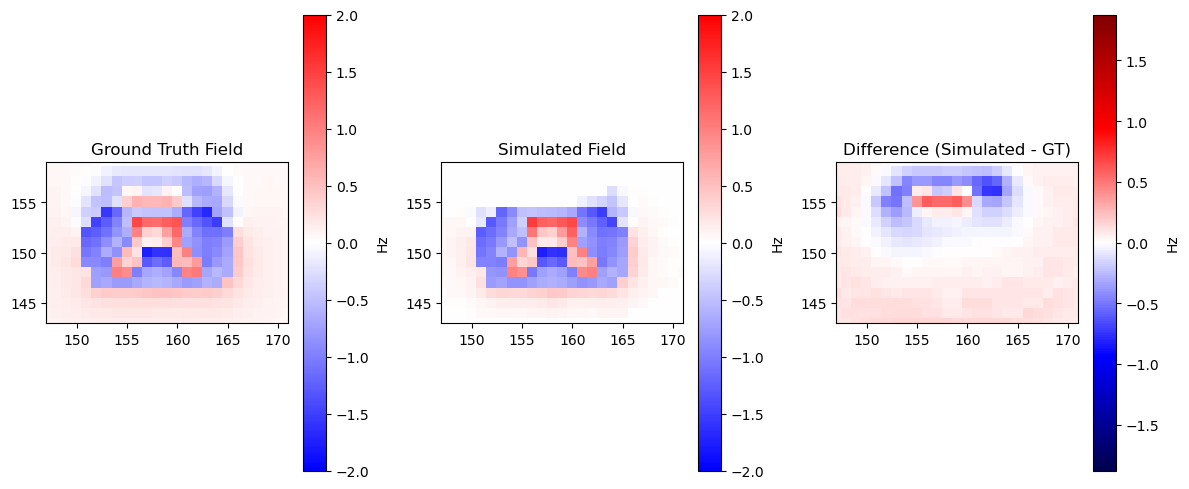

In [39]:
import matplotlib.pyplot as plt
print(f"Mean difference: {mean_diff:.5f}")
print(f"Std deviation of difference: {std_diff:.5f}")
print(f"RMSE: {rmse_diff:.5f}")

# Visualize the difference (middle axial slice as an example)
slice_index = 36# pixel_wise_difference.shape[2] // 2
plt.figure(figsize=(12, 5))

cmap_min = -2
cmap_max =2

plt.subplot(1, 3, 1)
plt.imshow(wb_gt_csf_ref_swiss_crop_fm_Hz_data[:, :, slice_index].T, cmap='bwr', vmin=cmap_min, vmax=cmap_max)
plt.title('Ground Truth Field')
plt.xlim(147, 171)
plt.ylim(143, 159)
plt.colorbar(label='Hz')

plt.subplot(1, 3, 2)
plt.imshow(test_local_field_Hz_data[:, :, slice_index].T, cmap='bwr',  vmin=cmap_min, vmax=cmap_max)
plt.title('Simulated Field')
plt.xlim(147, 171)
plt.ylim(143, 159)
plt.colorbar(label='Hz')

plt.subplot(1, 3, 3)
plt.imshow(pixel_wise_difference[:, :, slice_index].T, cmap='seismic', origin='lower', vmin=-np.max(np.abs(pixel_wise_difference)), vmax=np.max(np.abs(pixel_wise_difference)))
plt.title('Difference (Simulated - GT)')
plt.xlim(147, 171)
plt.ylim(143, 159)
plt.colorbar(label='Hz')

plt.tight_layout()
plt.show()

In [29]:
# Now lets load a "better" Local field?
better_local_field_test = nib.load(r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\MR_simulations\sim_data\QSM_processing\mrsim_outputs\custom_acq_params\BGFR_tests\iter_LBV\lbv_run92/Sepia_localfield.nii.gz").get_fdata()

Mean difference: -0.00005
Std deviation of difference: 0.00921
RMSE: 0.00921


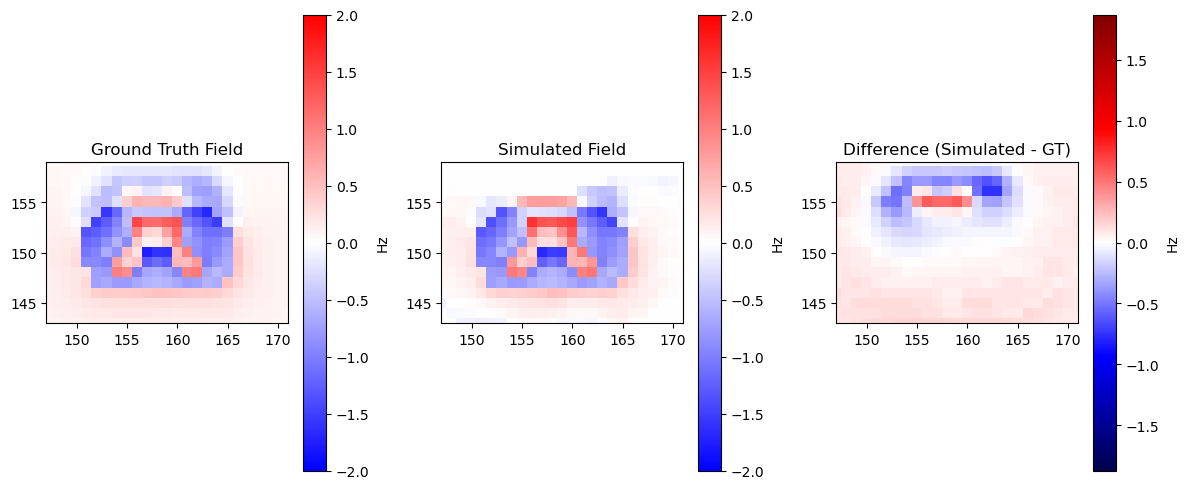

In [40]:
# Compute pixel wise difference:
pixel_wise_difference2 = wb_gt_csf_ref_swiss_crop_fm_Hz_data - better_local_field_test
# Compute difference metrics:
import numpy as np
mean_diff2 = np.mean(pixel_wise_difference2)
std_diff2 = np.std(pixel_wise_difference2)
rmse_diff2 = np.sqrt(np.mean(pixel_wise_difference2**2))

print(f"Mean difference: {mean_diff2:.5f}")
print(f"Std deviation of difference: {std_diff2:.5f}")
print(f"RMSE: {rmse_diff2:.5f}")

# Visualize the difference (middle axial slice as an example)
# Visualize the difference (middle axial slice as an example)
slice_index = 36# pixel_wise_difference.shape[2] // 2
plt.figure(figsize=(12, 5))

cmap_min = -2
cmap_max =2

plt.subplot(1, 3, 1)
plt.imshow(wb_gt_csf_ref_swiss_crop_fm_Hz_data[:, :, slice_index].T, cmap='bwr', vmin=cmap_min, vmax=cmap_max)
plt.title('Ground Truth Field')
plt.xlim(147, 171)
plt.ylim(143, 159)
plt.colorbar(label='Hz')

plt.subplot(1, 3, 2)
plt.imshow(better_local_field_test[:, :, slice_index].T, cmap='bwr',  vmin=cmap_min, vmax=cmap_max)
plt.title('Simulated Field')
plt.xlim(147, 171)
plt.ylim(143, 159)
plt.colorbar(label='Hz')

plt.subplot(1, 3, 3)
plt.imshow(pixel_wise_difference[:, :, slice_index].T, cmap='seismic', origin='lower', vmin=-np.max(np.abs(pixel_wise_difference2)), vmax=np.max(np.abs(pixel_wise_difference2)))
plt.title('Difference (Simulated - GT)')
plt.xlim(147, 171)
plt.ylim(143, 159)
plt.colorbar(label='Hz')

plt.tight_layout()
plt.show()

### <span style="color:#4FC3F7"> Using GM and GM masks for metric calculation </span> </br>

In [41]:
gm_mask_data = nib.load(r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\MR_simulations\sim_data\QSM_processing/gm_mask_crop.nii.gz").get_fdata()
wm_mask_data = nib.load(r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\MR_simulations\sim_data\QSM_processing/wm_mask_crop.nii.gz").get_fdata()

In [42]:
pixel_wise_difference = wb_gt_csf_ref_swiss_crop_fm_Hz_data - test_local_field_Hz_data

gm_diff = pixel_wise_difference[gm_mask_data==1]
wm_diff = pixel_wise_difference[wm_mask_data==1]

gm_mean_diff = np.mean(gm_diff)
gm_std_diff = np.std(gm_diff)
gm_rmse = np.sqrt(np.mean(gm_diff ** 2))

wm_mean_diff = np.mean(wm_diff)
wm_std_diff = np.std(wm_diff)
wm_rmse = np.sqrt(np.mean(wm_diff ** 2))

In [43]:
print("GM vs GT")
print(f"  Mean difference: {gm_mean_diff:.5f}")
print(f"  Std deviation: {gm_std_diff:.5f}")
print(f"  RMSE: {gm_rmse:.5f}")

print("WM vs GT")
print(f"  Mean difference: {wm_mean_diff:.5f}")
print(f"  Std deviation: {wm_std_diff:.5f}")
print(f"  RMSE: {wm_rmse:.5f}")

GM vs GT
  Mean difference: -0.07615
  Std deviation: 0.53171
  RMSE: 0.53714
WM vs GT
  Mean difference: -0.49188
  Std deviation: 0.47677
  RMSE: 0.68503


In [45]:
# Now with the "better" local field
pixel_wise_difference2 = wb_gt_csf_ref_swiss_crop_fm_Hz_data - better_local_field_test

gm_diff2 = pixel_wise_difference2[gm_mask_data==1]
wm_diff2 = pixel_wise_difference2[wm_mask_data==1]

gm_mean_diff2 = np.mean(gm_diff2)
gm_std_diff2 = np.std(gm_diff2)
gm_rmse2 = np.sqrt(np.mean(gm_diff2 ** 2))

wm_mean_diff2 = np.mean(wm_diff2)
wm_std_diff2 = np.std(wm_diff2)
wm_rmse2 = np.sqrt(np.mean(wm_diff2 ** 2))

In [46]:
print("GM vs GT")
print(f"  Mean difference: {gm_mean_diff2:.5f}")
print(f"  Std deviation: {gm_std_diff2:.5f}")
print(f"  RMSE: {gm_rmse2:.5f}")

print("WM vs GT")
print(f"  Mean difference: {wm_mean_diff2:.5f}")
print(f"  Std deviation: {wm_std_diff2:.5f}")
print(f"  RMSE: {wm_rmse2:.5f}")

GM vs GT
  Mean difference: -0.19439
  Std deviation: 0.35841
  RMSE: 0.40773
WM vs GT
  Mean difference: -0.29584
  Std deviation: 0.36826
  RMSE: 0.47238
